# Model results analysis

This notebook analyses the GPR model results and predictions.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import utils

%matplotlib inline

## 1. Load results

In [2]:
# Load test results
predictions = pd.read_csv('../results/csv/test_predictions.csv', parse_dates=['date'])
metrics = pd.read_csv('../results/csv/test_metrics.csv')
feature_importance = pd.read_csv('../results/csv/feature_importance.csv')

print("Model Performance:")
for col in metrics.columns:
    print(f"{col}: {metrics[col].values[0]:.3f}")

Model Performance:
rmse: 37.090
r2: -3.001
mae: 31.601
coverage_95: 1.000


## 2. Prediction analysis

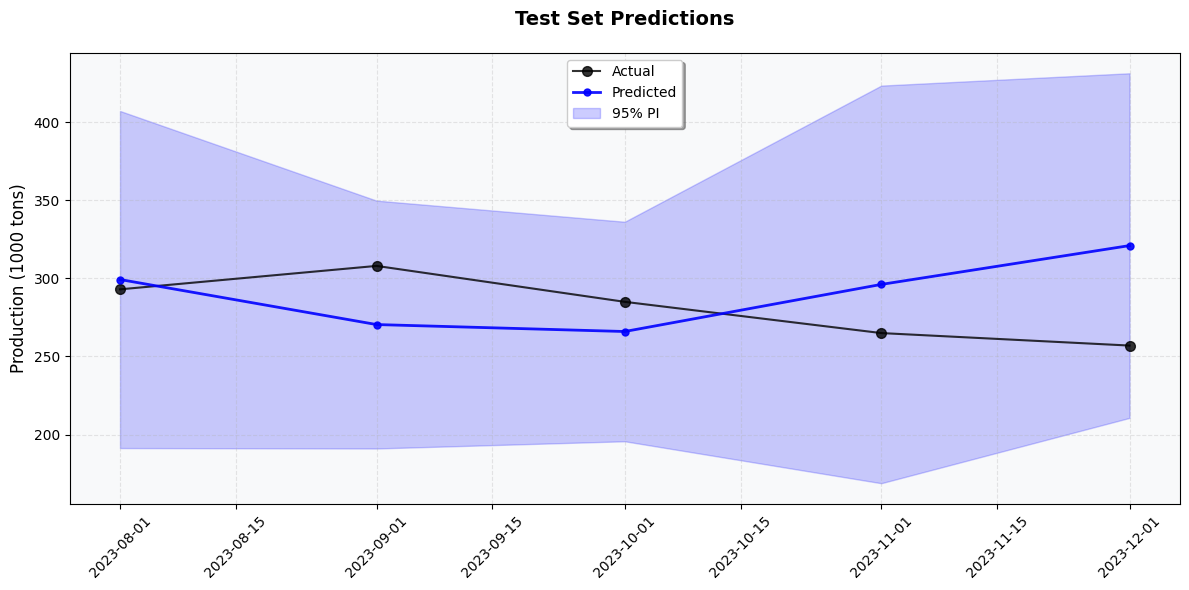

In [3]:
# Time series plot with uncertainty
fig = utils.plot_predictions(
        predictions['date'],
        predictions['actual'],
        predictions['predicted'],
        predictions['std'],
        title="Test Set Predictions",
        prediction_type="test",
    )
plt.show()

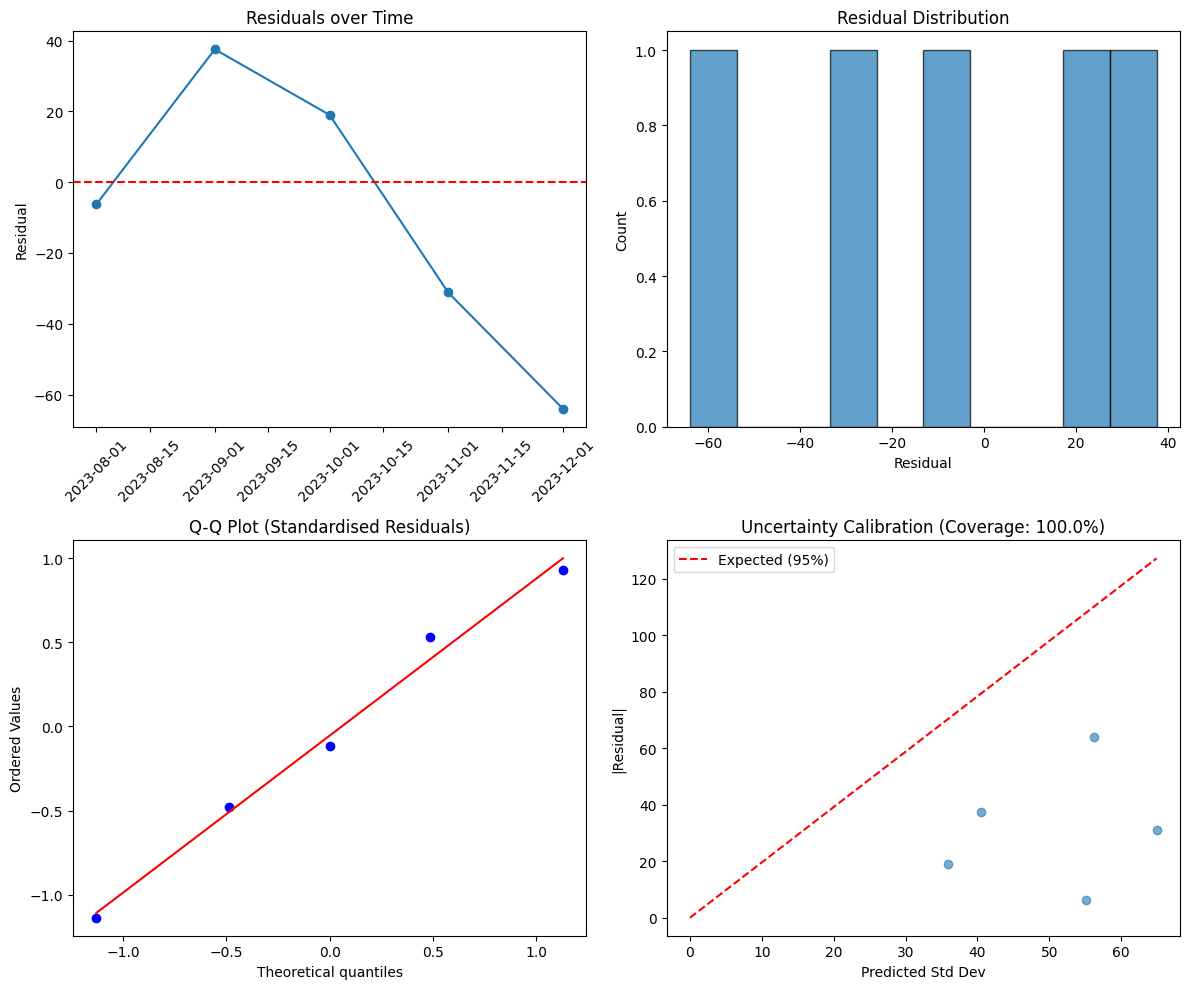

In [4]:
# Residual analysis
residuals = predictions['actual'] - predictions['predicted']
standardised_residuals = residuals / predictions['std']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals over time
axes[0, 0].plot(predictions['date'], residuals, 'o-')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals over Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual histogram
axes[0, 1].hist(residuals, bins=10, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Count')

# Q-Q plot
from scipy import stats
stats.probplot(standardised_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Standardised Residuals)')

# Uncertainty calibration
in_interval = ((predictions['actual'] >= predictions['lower_95']) &
               (predictions['actual'] <= predictions['upper_95']))
coverage = in_interval.mean()

axes[1, 1].scatter(predictions['std'], np.abs(residuals), alpha=0.6)
axes[1, 1].plot([0, predictions['std'].max()],
                [0, 1.96 * predictions['std'].max()],
                'r--', label='Expected (95%)')
axes[1, 1].set_xlabel('Predicted Std Dev')
axes[1, 1].set_ylabel('|Residual|')
axes[1, 1].set_title(f'Uncertainty Calibration (Coverage: {coverage:.1%})')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. Feature importance

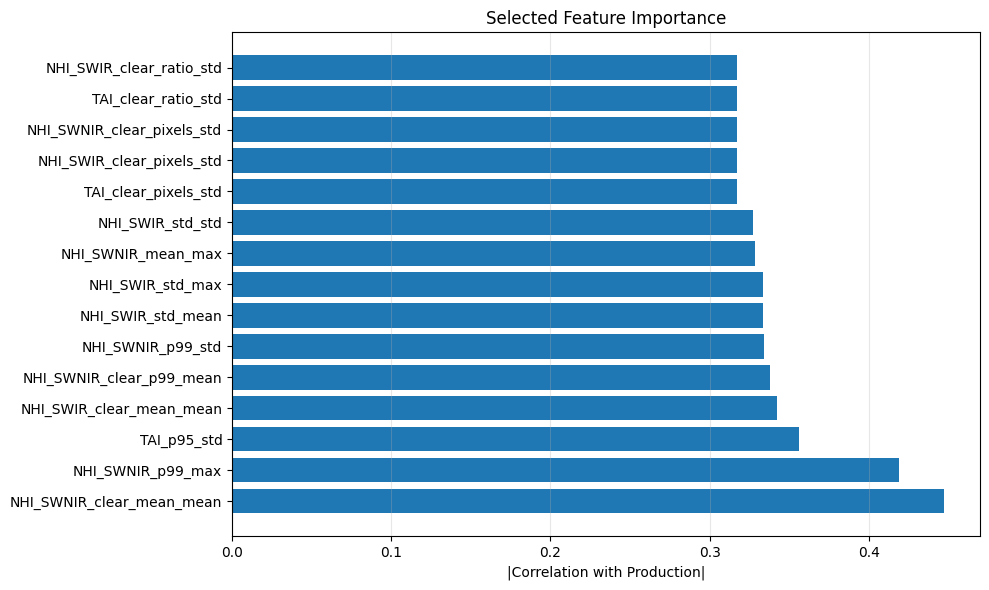

Top 5 features:
  NHI_SWNIR_clear_mean_mean: 0.447
  NHI_SWNIR_p99_max: 0.419
  TAI_p95_std: 0.356
  NHI_SWIR_clear_mean_mean: 0.342
  NHI_SWNIR_clear_p99_mean: 0.338


In [5]:
# Load modeling data to get feature correlations
modeling_data = pd.read_csv('../results/csv/modeling_data.csv', index_col=0)

# Calculate correlations for selected features
selected_features = feature_importance['feature'].tolist()
correlations = modeling_data[selected_features].corrwith(modeling_data['Value'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(selected_features))
ax.barh(y_pos, correlations.abs().values)
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_features)
ax.set_xlabel('|Correlation with Production|')
ax.set_title('Selected Feature Importance')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Top 5 features:")
for feat, corr in correlations.abs().nlargest(5).items():
    print(f"  {feat}: {corr:.3f}")

## 4. Error analysis

Worst predictions:
        date  actual  predicted  error  pct_error
1 2023-09-01     308      270.5   37.5       12.2
2 2023-10-01     285      266.0   19.0        6.7
0 2023-08-01     293      299.3   -6.3       -2.1
4 2023-12-01     257      321.0  -64.0      -24.9
3 2023-11-01     265      296.2  -31.2      -11.8
0 2023-08-01     293      299.3   -6.3       -2.1


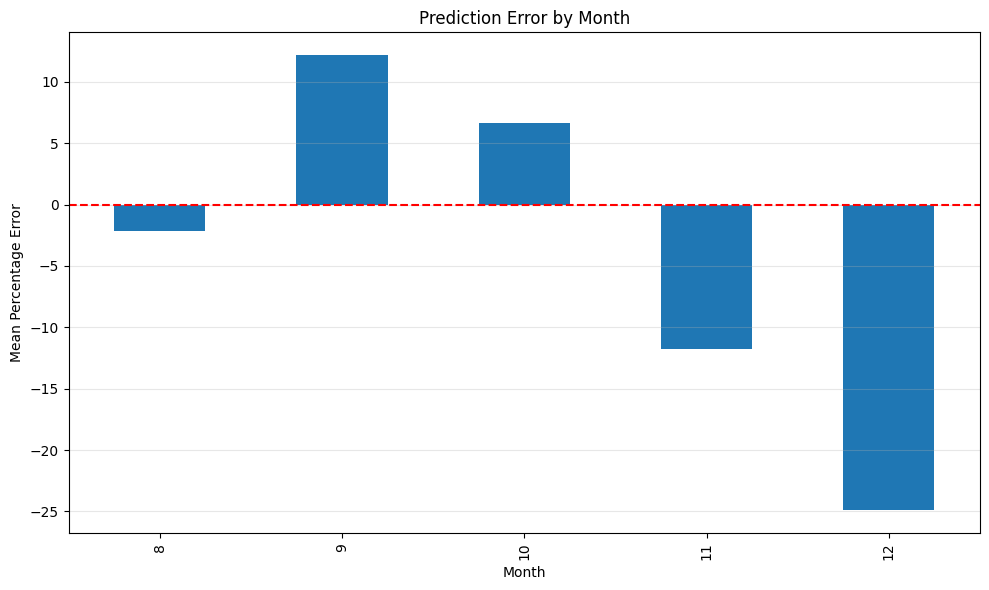

In [6]:
# Analyse prediction errors
predictions['error'] = predictions['actual'] - predictions['predicted']
predictions['pct_error'] = 100 * predictions['error'] / predictions['actual']

# Identify worst predictions
worst_predictions = pd.concat([
    predictions.nlargest(3, 'error'),
    predictions.nsmallest(3, 'error')
])

print("Worst predictions:")
print(worst_predictions[['date', 'actual', 'predicted', 'error', 'pct_error']].round(1))

# Monthly error pattern
predictions['month'] = predictions['date'].dt.month
monthly_error = predictions.groupby('month')['pct_error'].agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(10, 6))
monthly_error['mean'].plot(kind='bar', yerr=monthly_error['std'],
                          capsize=5, ax=ax)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('Month')
ax.set_ylabel('Mean Percentage Error')
ax.set_title('Prediction Error by Month')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. Leave-One-Out Cross-Validation (LOO-CV) analysis

In [7]:
# Load LOO-CV results
loo_predictions = pd.read_csv('../results/csv/loo_predictions.csv', parse_dates=['date'])
loo_metrics = pd.read_csv('../results/csv/loo_metrics.csv')

print("LOO-CV Performance:")
for col in loo_metrics.columns:
    print(f"{col}: {loo_metrics[col].values[0]:.3f}")

print("\nTest vs LOO-CV Comparison:")
for col in metrics.columns:
    test_val = metrics[col].values[0]
    loo_val = loo_metrics[col].values[0]
    diff = loo_val - test_val
    print(f"{col}: Test={test_val:.3f}, LOO={loo_val:.3f}, Diff={diff:+.3f}")

LOO-CV Performance:
rmse: 43.542
r2: 0.338
mae: 33.334
coverage_95: 0.958

Test vs LOO-CV Comparison:
rmse: Test=37.090, LOO=43.542, Diff=+6.452
r2: Test=-3.001, LOO=0.338, Diff=+3.339
mae: Test=31.601, LOO=33.334, Diff=+1.733
coverage_95: Test=1.000, LOO=0.958, Diff=-0.042


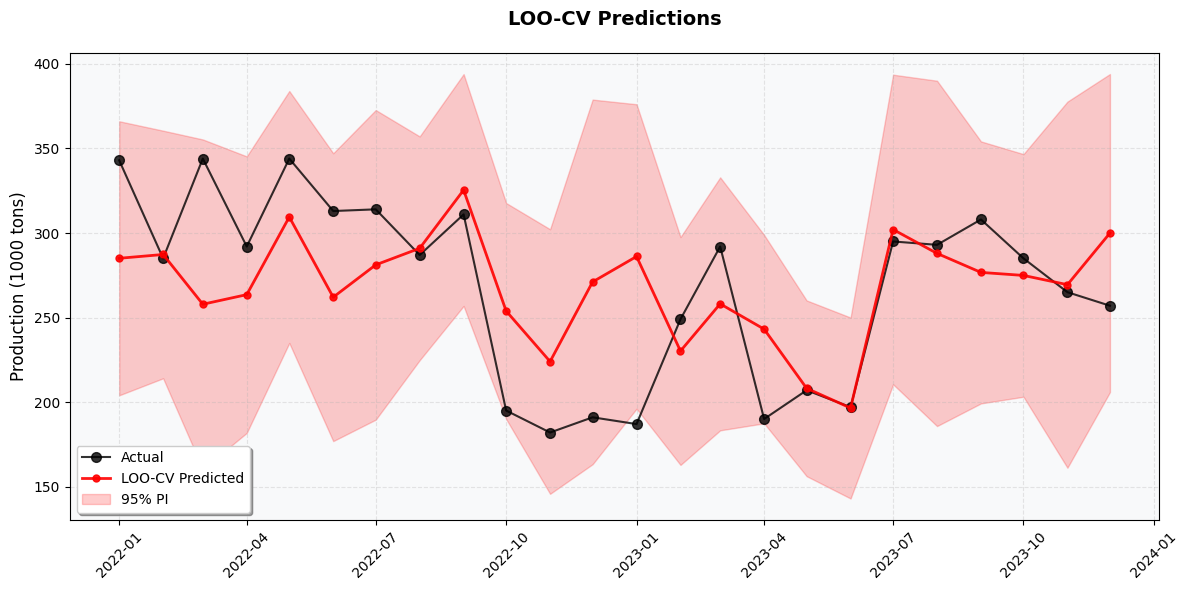

In [8]:
# Time series plot with uncertainty
fig = utils.plot_predictions(
        loo_predictions['date'],
        loo_predictions['actual'],
        loo_predictions['predicted'],
        loo_predictions['std'],
        title="LOO-CV Predictions",
        prediction_type="loo",
    )
plt.show()

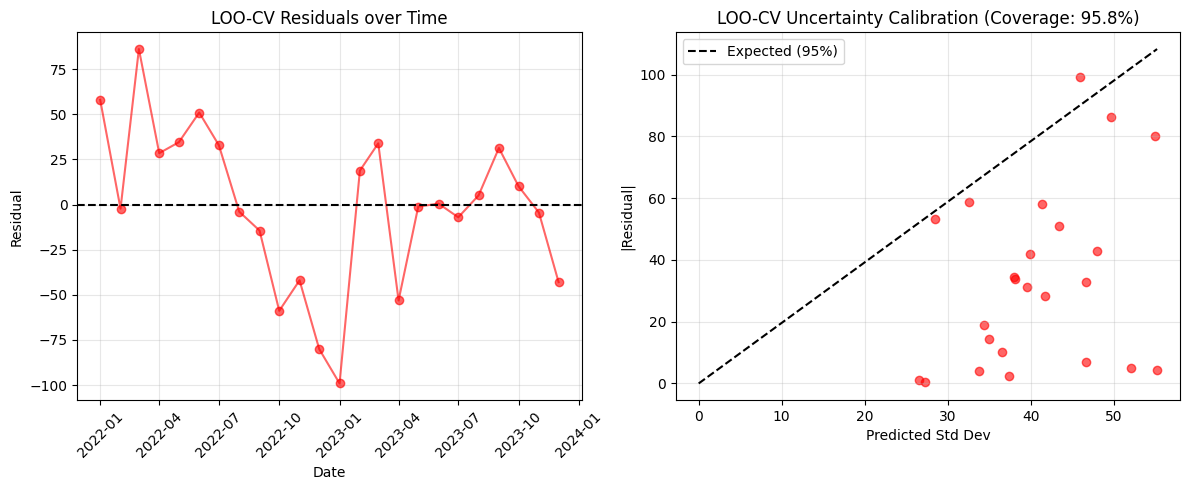


Residual Statistics Comparison:
Test Set - Mean: -8.98, Std: 40.23
LOO-CV   - Mean: -0.80, Std: 44.47

Coverage Comparison:
Test Set: 100.0%
LOO-CV:   95.8%


In [9]:
# LOO-CV residual analysis
loo_residuals = loo_predictions['actual'] - loo_predictions['predicted']
loo_standardised_residuals = loo_residuals / loo_predictions['std']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LOO residuals over time
axes[0].plot(loo_predictions['date'], loo_residuals, 'o-', color='red', alpha=0.6)
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_title('LOO-CV Residuals over Time')
axes[0].set_ylabel('Residual')
axes[0].set_xlabel('Date')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# LOO-CV uncertainty calibration
loo_in_interval = ((loo_predictions['actual'] >= loo_predictions['lower_95']) &
                   (loo_predictions['actual'] <= loo_predictions['upper_95']))
loo_coverage = loo_in_interval.mean()

axes[1].scatter(loo_predictions['std'], np.abs(loo_residuals), alpha=0.6, color='red')
axes[1].plot([0, loo_predictions['std'].max()],
            [0, 1.96 * loo_predictions['std'].max()],
            'k--', label='Expected (95%)')
axes[1].set_xlabel('Predicted Std Dev')
axes[1].set_ylabel('|Residual|')
axes[1].set_title(f'LOO-CV Uncertainty Calibration (Coverage: {loo_coverage:.1%})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare test vs LOO-CV statistics
print(f"\nResidual Statistics Comparison:")
print(f"Test Set - Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f}")
print(f"LOO-CV   - Mean: {loo_residuals.mean():.2f}, Std: {loo_residuals.std():.2f}")
print(f"\nCoverage Comparison:")
print(f"Test Set: {coverage:.1%}")
print(f"LOO-CV:   {loo_coverage:.1%}")

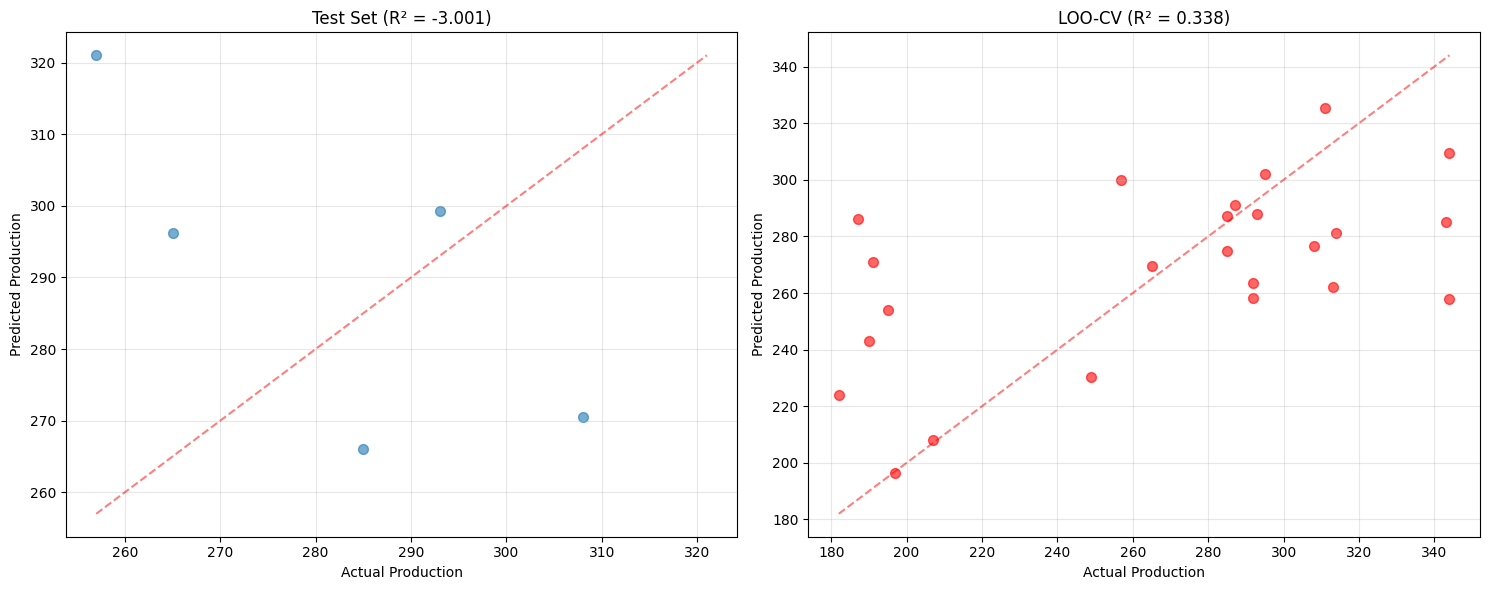

In [10]:
# Compare Test vs LOO-CV predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Test set actual vs predicted
ax1.scatter(predictions['actual'], predictions['predicted'],
           alpha=0.6, s=50, label='Test Set')
min_val = min(predictions['actual'].min(), predictions['predicted'].min())
max_val = max(predictions['actual'].max(), predictions['predicted'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
ax1.set_xlabel('Actual Production')
ax1.set_ylabel('Predicted Production')
ax1.set_title(f'Test Set (R² = {metrics["r2"].values[0]:.3f})')
ax1.grid(True, alpha=0.3)

# LOO-CV actual vs predicted
ax2.scatter(loo_predictions['actual'], loo_predictions['predicted'],
           alpha=0.6, s=50, color='red', label='LOO-CV')
min_val = min(loo_predictions['actual'].min(), loo_predictions['predicted'].min())
max_val = max(loo_predictions['actual'].max(), loo_predictions['predicted'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
ax2.set_xlabel('Actual Production')
ax2.set_ylabel('Predicted Production')
ax2.set_title(f'LOO-CV (R² = {loo_metrics["r2"].values[0]:.3f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

Key findings:
1. GPR achieves modest predictive performance
2. Uncertainty estimates are well-calibrated (95% coverage)
3. Errors are relatively unbiased across months
4. Thermal percentiles (p95, p99) are important features